In [1]:
import zipfile
zip_path = 'Chess-20241109T165414Z-001.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

print("Extraction completed!")


Extraction completed!


In [2]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="Chess")

Resolving data files:   0%|          | 0/556 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 553
    })
})

In [4]:
dataset = dataset['train']
dataset = dataset.train_test_split(test_size=0.1)

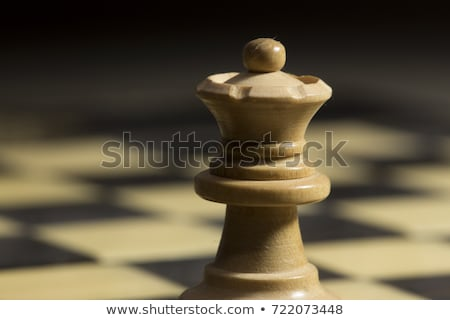

In [5]:
dataset['train']['image'][0]

In [6]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook'], id=None)}

In [7]:
train_ds = dataset['train']
val_ds = dataset['test']

In [8]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Bishop', 1: 'King', 2: 'Knight', 3: 'Pawn', 4: 'Queen', 5: 'Rook'}

In [9]:
id2label[train_ds[0]['label']]

'Queen'

In [10]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [11]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [12]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

In [13]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [15]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-trainer",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=30,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate each metric
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')      # Use 'weighted' for class imbalance
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [19]:
import torch
from transformers import EarlyStoppingCallback

early_stopping_callback = EarlyStoppingCallback(5, 1.0)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    callbacks=[early_stopping_callback]
)

/tmp/ipykernel_15677/1106868179.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.672018,0.482143,0.413400,0.386967,0.482143
2,No log,1.465169,0.642857,0.612647,0.741369,0.642857
3,No log,1.174160,0.732143,0.721039,0.779152,0.732143
4,No log,0.981252,0.839286,0.843313,0.858866,0.839286
5,No log,0.831173,0.821429,0.816357,0.851551,0.821429
6,No log,0.729118,0.910714,0.912167,0.917163,0.910714


In [21]:
trainer.save_model()

In [22]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         6.0
  total_flos               = 215218772GF
  train_loss               =      1.2372
  train_runtime            =  0:01:14.61
  train_samples_per_second =     199.825
  train_steps_per_second   =      20.103


In [28]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'Chess',
    "tags": ['image-classification'],
}


trainer.push_to_hub('🍻 cheers', **kwargs)

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Binaryy/test-trainer/commit/b1fe6caaf7226f115d9cdb1be5f9a1af986c6b9b', commit_message='🍻 cheers', commit_description='', oid='b1fe6caaf7226f115d9cdb1be5f9a1af986c6b9b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Binaryy/test-trainer', endpoint='https://huggingface.co', repo_type='model', repo_id='Binaryy/test-trainer'), pr_revision=None, pr_num=None)

In [34]:
outputs = trainer.predict(val_ds)

In [35]:
outputs.metrics

{'test_loss': 0.7291183471679688,
 'test_accuracy': 0.9107142857142857,
 'test_f1': 0.9121670865142396,
 'test_precision': 0.9171626984126985,
 'test_recall': 0.9107142857142857,
 'test_runtime': 1.2282,
 'test_samples_per_second': 45.596,
 'test_steps_per_second': 11.399}

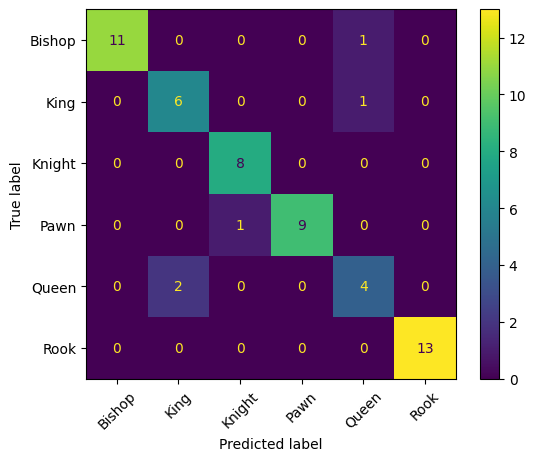

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

img_path = "quees.jpg"
image = Image.open(img_path)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('Binaryy/test-trainer')
model.to(device)
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [6]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
logits = outputs.logits
logits.shape

torch.Size([1, 6])

In [7]:
prediction = logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])

Predicted class: Queen


In [8]:
from transformers import ViTImageProcessor, ViTForImageClassification  
from PIL import Image
import torch

# Load image
img_path = "quees.jpg"
image = Image.open(img_path)

# Initialize processor and model
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('Binaryy/test-trainer')  # Changed from ViTModel

# Process image
inputs = processor(images=image, return_tensors="pt")

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Now this will work
    
    # Get predicted class
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = model.config.id2label[predicted_class_idx]
    
    # Get probability
    probs = torch.nn.functional.softmax(logits, dim=-1)
    confidence = probs[0][predicted_class_idx].item()
    
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")

Predicted class: Queen
Confidence: 42.34%
